# System Setup

In [1]:
import os
import re
import numpy as np
import pandas as pd
import mdtraj as md
import nglview as nv
import seaborn as sns
from glob import glob
from rdkit import Chem
from functions import *
from mplcursors import cursor
import matplotlib.pyplot as plt
from rdkit.Chem import PandasTools

In [2]:
## The Atomic Radii used for SASA calculation
_ATOMIC_RADII = {'H'   : 0.120, 'He'  : 0.140, 'Li'  : 0.076, 'Be' : 0.059,
                 'B'   : 0.192, 'C'   : 0.170, 'N'   : 0.155, 'O'  : 0.152,
                 'F'   : 0.147, 'Ne'  : 0.154, 'Na'  : 0.102, 'Mg' : 0.086,
                 'Al'  : 0.184, 'Si'  : 0.210, 'P'   : 0.180, 'S'  : 0.180,
                'Ca'   : 0.200, 'Cl'  : 0.200, 'Zn'  : 0.200, 'VS' : 0.152,
                 'I'   : 0.220, 'Br'  : 0.196 , 'A'  : 0.170,}

# Docking from AutoDock-GPU

## Read docking output

In [3]:
# get dlg files from GPU docking preocedure, saved in docking/ directory and initialise arrays
dlg_files = np.array(glob('docking/*.dlg'))
dlg_count = len(dlg_files)
min_score = np.zeros(dlg_count)
min_pose  = np.zeros(dlg_count,dtype=int)

# loop through files and save minimum docking score values with the pose/state
for i, dlg_file in enumerate(dlg_files):
    score = np.array(read_output(dlg_file,pattern=gpu_pattern))
    min_score[i] = np.min(score)
    min_pose[i]  = np.argmin(score) + 1

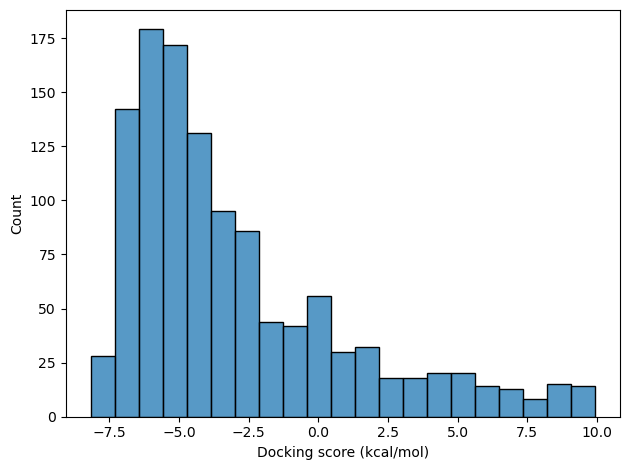

In [4]:
# make a histogram of dockingscores beneath 10kcal/mol and save it
sns.histplot(min_score[np.where(min_score < 10)])
plt.ylabel('Count')
plt.xlabel('Docking score (kcal/mol)')
plt.tight_layout()
plt.savefig('AutodockGPU_Score_distribution.jpeg')

In [8]:
# specify count of best ligands and calculate their indices by docking score and specify pdbqt path
top_n = 100
pdbqt_path = './PDBQT/{}pdbqt'
top_ids = np.argsort(min_score)[:top_n]

# loop through the indices of the ligands with lowest (best) docking score
for i in top_ids:
    
    # get the dlg file corresponding to that index, i and create pdbqt filename from it
    dlg_file = dlg_files[i]
    pdbqt_file = os.path.basename(dlg_file)[:-3]

    # open the dlg file and read each line
    with open(dlg_file,'r') as read:
        # initialise pose as -1 since for dlg file, all poses are being cycled through
        pose = -1
        # open the nascent pdbqt file for writing only the best pose
        with open(pdbqt_path.format(pdbqt_file),'w') as write:
            for line in read:
                # MODEL in dlg file refers to state/pose
                if 'MODEL' in line:
                    # assign the corresponding MODEL value to pose variable
                    pose = int(line.split('MODEL')[1])
                if pose == min_pose[i]:
                    # for the best pose print every line to the pdbqt file until 'ENDMDL' is reached
                    print(line.replace('DOCKED: ',''),end='',file=write)
                    if 'ENDMDL' in line:
                        break

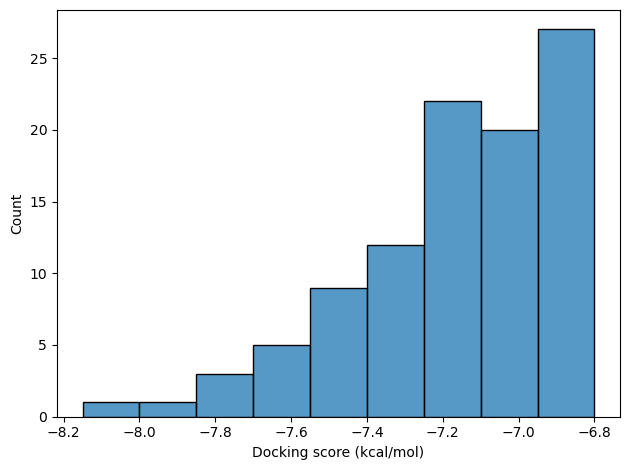

In [9]:
# to make sure all the remaining 100 compounds have a goodd score, yet another histogram
sns.histplot(min_score[top_ids])
plt.ylabel('Count')
plt.xlabel('Docking score (kcal/mol)')
plt.tight_layout()
plt.savefig('AutodockGPU_minScore_distribution.jpeg')

In [10]:
# execute convert.sh found in this directory which converts the pdbqt files into SMILES, MOL2, PDB
!./convert.sh

./PDBQT/Ligand_0043
1 molecule converted
1 molecule converted
1 molecule converted
./PDBQT/Ligand_0051
1 molecule converted
1 molecule converted
1 molecule converted
./PDBQT/Ligand_0067
1 molecule converted
1 molecule converted
1 molecule converted
./PDBQT/Ligand_0072
1 molecule converted
1 molecule converted
1 molecule converted
./PDBQT/Ligand_0084
1 molecule converted
1 molecule converted
1 molecule converted
./PDBQT/Ligand_0093
1 molecule converted
1 molecule converted
1 molecule converted
./PDBQT/Ligand_0107
1 molecule converted
1 molecule converted
1 molecule converted
./PDBQT/Ligand_0135
1 molecule converted
1 molecule converted
1 molecule converted
./PDBQT/Ligand_0140
1 molecule converted
1 molecule converted
1 molecule converted
./PDBQT/Ligand_0156
1 molecule converted
1 molecule converted
1 molecule converted
./PDBQT/Ligand_0169
1 molecule converted
1 molecule converted
1 molecule converted
./PDBQT/Ligand_0179
1 molecule converted
1 molecule converted
1 molecule converted
./PD

## Calculate BSA and Visualise Compounds

In [11]:
# Path to receptor file
AB_path = '../01_receptor_prep/hmx.B99990001.pdb'

# Load the file with mdtraj and convert to table
AB = md.load(AB_path)
table, _ = AB.topology.to_dataframe()

# from the table get the atom indices, coords and elements for both proteins
A_ids = table.query('chainID == 0').index
B_ids = table.query('chainID == 1').index
A_xyz = AB.xyz[:,A_ids]
B_xyz = AB.xyz[:,B_ids]
A_elems = table.loc[A_ids,'element'].values
B_elems = table.loc[B_ids,'element'].values

# SASA calculation with external function 
### would be better if we wrote functions.Sasa_calc, then its clear where the function comes from
A_Radii    = [_ATOMIC_RADII[element] for element in A_elems]
B_Radii    = [_ATOMIC_RADII[element] for element in B_elems]  
A_SASA     = Sasa_calc(A_xyz,A_Radii)[0]
B_SASA     = Sasa_calc(B_xyz,B_Radii)[0]

In [12]:
pdb_path = 'PDB/{}.pdb'
smi_path = 'SMI/{}.smi'

# instantiate lists to be filled by the for loop
L_ids = []
L_smis = []
L_SASA = []
AL_SASA = []
BL_SASA = []

# Loop over indices of the top ligands
for i in top_ids:
    
    # get the ligand names from the dlg files and extract the ID number with regex
    L_name = os.path.basename(dlg_files[i][:-4])
    L_ids.append(re.search(re.compile(r'[0-9]+'),L_name).group(0))
    
    # fetch the smiles strings for the SMILES dataframe
    L_smi = smi_path.format(L_name)
    L_smis.append(np.loadtxt(L_smi,dtype=str)[0].split('\t')[0])
    
    # calculate the SASA for BSA calculation from the mdtraj object of the ligand with hardcoded radii
    L = md.load(pdb_path.format(L_name))    
    L_Radii = [_ATOMIC_RADII[atom.element.symbol] for atom in L.topology.atoms] 
    L_SASA.append(Sasa_calc(L.xyz,L_Radii)[0])
    AL_SASA.append(Sasa_calc(np.concatenate([A_xyz, L.xyz],axis=1),A_Radii + L_Radii)[0])
    BL_SASA.append(Sasa_calc(np.concatenate([B_xyz, L.xyz],axis=1),B_Radii + L_Radii)[0])

In [13]:
# convert the lists into numpy arrays for better data handling
L_SASA = np.array(L_SASA)
AL_SASA = np.array(AL_SASA)
BL_SASA = np.array(BL_SASA)

# prepare the data and the columns for a proper data frame
L_data = np.array([min_score[top_ids], L_SASA, AL_SASA, BL_SASA]).T
L_cols = ['D_Score','SASA_L','SASA_AL','SASA_BL']

# Create Data table and calculate additional properties important for identification of good ligands
df_L = pd.DataFrame(L_data, columns=L_cols)
df_L['Ligand'] = L_ids
df_L['BSA_AL'] = L_SASA + A_SASA - AL_SASA
df_L['BSA_BL'] = L_SASA + B_SASA - BL_SASA
df_L['BSA_min'] = df_L[['BSA_AL','BSA_BL']].values.min(axis=1)

## Data visualization

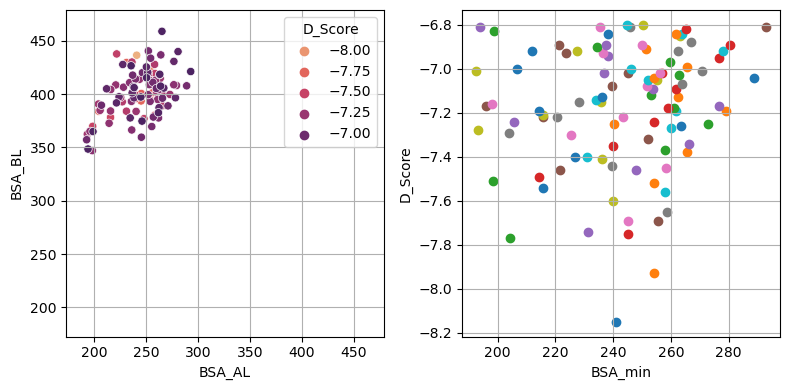

In [14]:
# Plot the BSA metrics and save the figure
fig, axs = plt.subplots(1,2,figsize=(8,4))
plot_BSA_Score(df_L, 
               xcol='BSA_AL',
               ycol='BSA_BL',
               min_col='BSA_min',
               score='D_Score', 
               axs = axs,
              show_legend=False)
plt.savefig('GPU_BSA_dockingscore.jpeg', dpi=450)

In [15]:
# mplcursors.cursor enables to get informations about a data point in the plot, which eases picking a good ligand
%matplotlib qt

fig, axs = plt.subplots(1,1,figsize=(5,4))
ax = df_L.plot(kind='scatter', x='BSA_min', y='D_Score', ax=axs)

cr = cursor(ax, hover=True)
cr.connect("add", lambda sel: sel.annotation.set_text((df_L.loc[sel.index, ["Ligand"]].to_string())))
@cr.connect("add")

def _(sel):
    sel.annotation.get_bbox_patch().set(fc="white")
    sel.annotation.arrow_patch.set(arrowstyle="simple", fc="white", alpha=.5)

plt.grid()
plt.tight_layout()
plt.show()

In [16]:
%matplotlib inline

## Structure Visualization

In [19]:
L_path='PDB/Ligand_0156.pdb'
view = nv.show_mdtraj(AB)
show_ligand(view,L_path)
view

NGLWidget()

,ID,Score,SMILES,Molecule
0,0156,-8.15,C1(=[C][C]=[C][C]=C1NC(=O)C(=O)O)C(=O)N[C]([C]...,

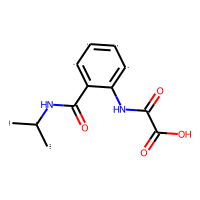

In [18]:
# create SMILES dataframe for convenient compound visualisation
df_smi = pd.DataFrame(columns=['ID','Score','SMILES'])
df_smi['ID'] = L_ids
df_smi['Score'] = min_score[top_ids]
df_smi['SMILES'] = L_smis
# the error mentioned in the script with '_get_adjustment' comes into play here, if not fixed yet, theres an error
PandasTools.AddMoleculeColumnToFrame(df_smi,'SMILES','Molecule')
df_smi.query('ID == "0156"')